In [99]:
# 머신러닝 목적 : 대출 얼마를 할지 예측.
# step1 : 자료탐색
# step2 : 자료분석
# step3 : 대출에 영향을 미치는 features 탐색
# step4 : 정답지 대출과 상관관계 분석
# step5 : 예측
# step6 : 정확도 검증

There is a row: 614 and columns: 13
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data

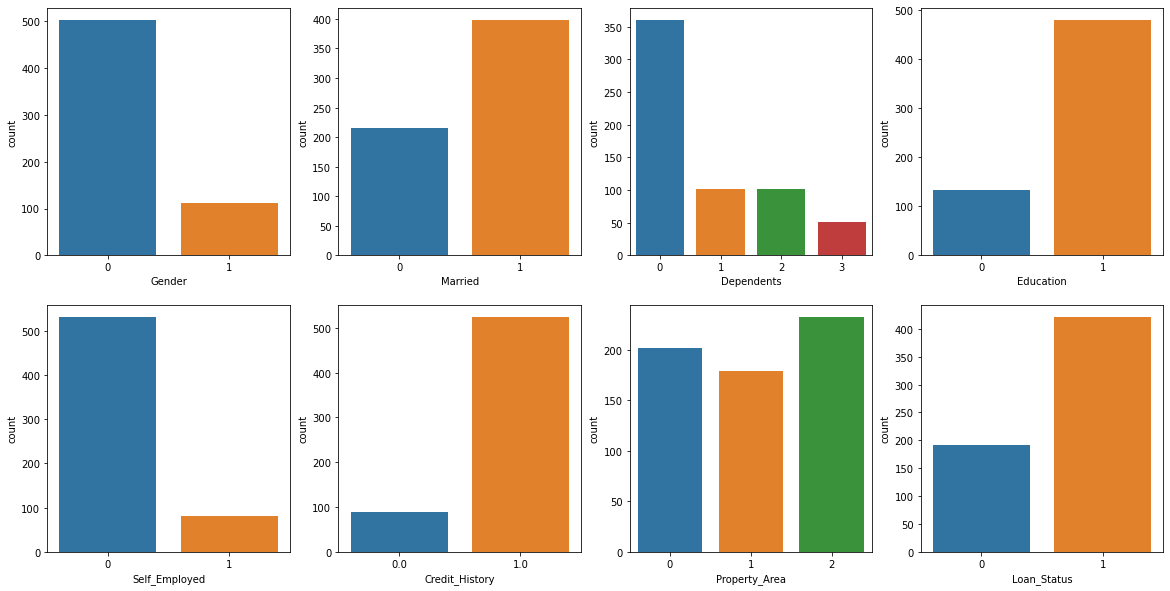

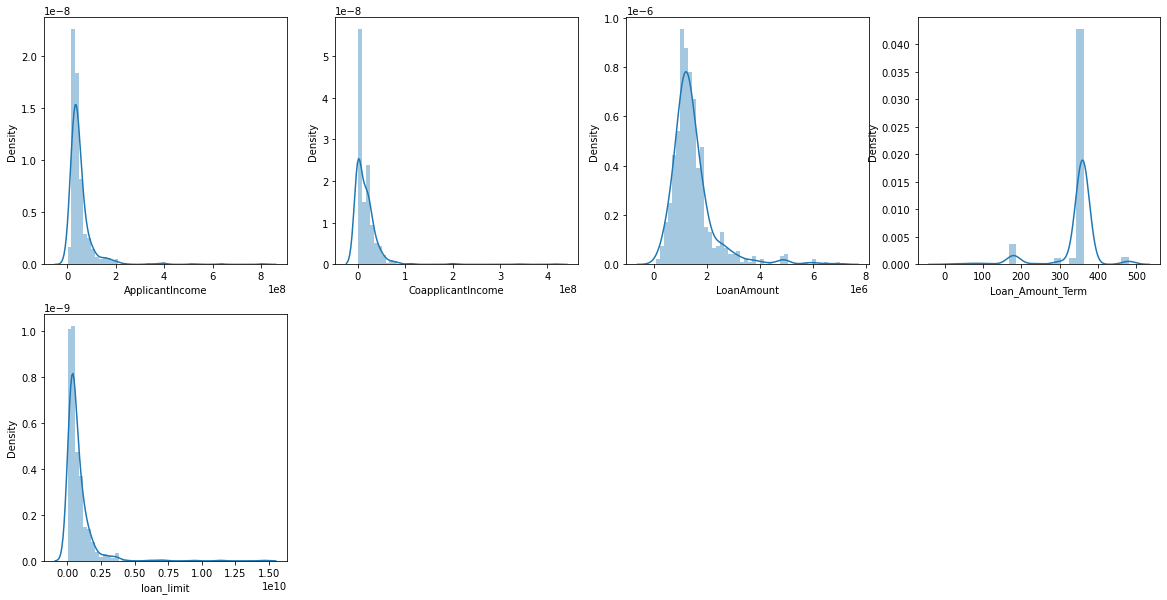

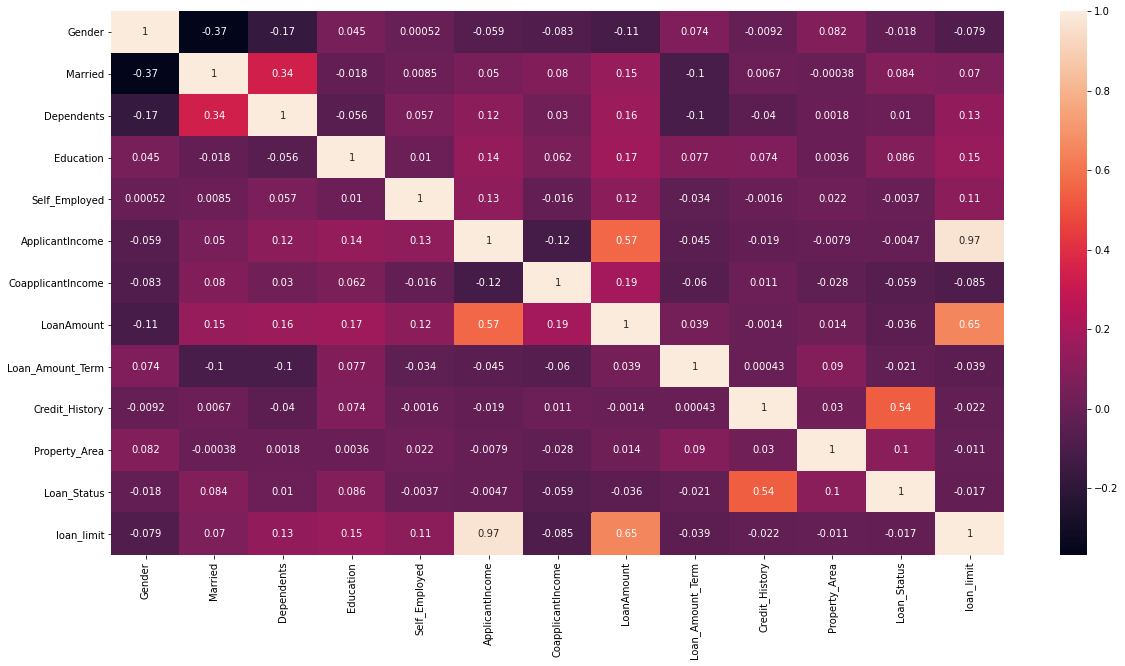

In [114]:
# 1. 라이브러리 선언

import pandas as pd
import numpy as np
from random import *
# 분석 라이브러리

# 분석알고리즘 DecisionTree 구현 라이브러리
from sklearn.tree import DecisionTreeRegressor # 설명력이 뛰어남
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression   # 이 3가지를 제일 많이 씀
from sklearn.metrics import accuracy_score
# 과거데이터를 8:2, 7:3 으로 자동으로 나누어주는 함수
from sklearn.model_selection import train_test_split

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings(action = 'ignore')

# 2. 데이터 불러오기

try:
    loanData = pd.read_csv('../위세_프로젝트_파일/train_u6lujuX_CVtuZ9i (1).csv')
except Exception as e:
    print(e)

loanData.head()

loanData.shape
print("There is a row:" ,loanData.shape[0], "and columns:", loanData.shape[1] )

loanData.describe()

loanData.info()





loanData.nunique()

loanData.columns

# 3.데이터 전처리

# 데이터 타입 통합.
loanData = loanData.astype({ "Loan_ID" : str,
                            "Gender" : str,
                            "Married" : str,
                            "Dependents" : str,
                            "Education" : str,
                            "Self_Employed" : str,
                            "ApplicantIncome" : int,
                            "CoapplicantIncome" : float,
                            "LoanAmount" : float,
                            "Loan_Amount_Term" : float,
                            "Credit_History" : float,
                            "Property_Area" : str,
                            "Loan_Status" : str})

loanData.info()

loanData.isnull().sum()

# mode()집계함수. 최빈값 확인
loanData["Gender"].mode()[0]
loanData['Dependents'].mode()[0]
loanData['Self_Employed'].mode()[0]
loanData['Credit_History'].mode()[0]
loanData['Married'].mode()[0]

# 결측값 처리.
loanData['Gender'] = loanData['Gender'].fillna(loanData['Gender'].mode()[0])
loanData['Dependents'] = loanData['Dependents'].fillna(loanData['Dependents'].mode()[0])
loanData['Self_Employed'] = loanData['Self_Employed'].fillna(loanData['Self_Employed'].mode()[0])
loanData['Credit_History'] = loanData['Credit_History'].fillna(loanData['Credit_History'].mode()[0])
loanData['Married'] = loanData['Married'].fillna(loanData['Married'].mode()[0])
loanData['LoanAmount'] = loanData['LoanAmount'].fillna(loanData['LoanAmount'].mean())
loanData['Loan_Amount_Term'] = loanData['Loan_Amount_Term'].fillna(loanData['Loan_Amount_Term'].mean())

# 결측값 확인
loanData.isnull().sum()

# 원화로 변경.
money = 10000
loanData.ApplicantIncome = loanData.ApplicantIncome*money
loanData.CoapplicantIncome = loanData.CoapplicantIncome*money
loanData.LoanAmount = loanData.LoanAmount*money


# 대출 한도 생성.
amount = 23
limit_rows = []
limit_columns = []
amountMean = loanData.LoanAmount.median()
amountMean



for i in range(0,614):
    if(loanData.LoanAmount.iloc[i] > amountMean):
        amount = 20
    else :
        amount = 10
    
    if(loanData.Married.iloc[i] == 0 and loanData.Education.iloc[i] == 0):
        limit_columns.append(loanData.ApplicantIncome.iloc[i] * 0.6 * amount)
        limit_rows.append(limit_columns)
        limit_columns = []
    elif(loanData.Married.iloc[i] == 0 and loanData.Education.iloc[i] == 1):
        limit_columns.append(loanData.ApplicantIncome.iloc[i] * 0.7 * amount)
        limit_rows.append(limit_columns)
        limit_columns = []
    elif(loanData.Married.iloc[i] == 1 and loanData.Education.iloc[i] == 0):
        limit_columns.append(loanData.ApplicantIncome.iloc[i] * 0.8 * amount)
        limit_rows.append(limit_columns)
        limit_columns = []
    else :
        limit_columns.append(loanData.ApplicantIncome.iloc[i] * 0.9 * amount)
        limit_rows.append(limit_columns)
        limit_columns = []
limitDf = pd.DataFrame(limit_rows)
limitDf = limitDf.rename(columns = {0 : 'loan_limit'})
loanData = pd.concat([loanData,limitDf], axis = 1)
loanData.loan_limit.max()

# 라벨링 작업

loanStatusMap = {"Y" : 1, "N" : 0}
marriedMap = {"Yes" : 1, "No" : 0, "nan" : 0}
educationMap = {"Graduate" : 1, "Not Graduate" : 0, "nan" : 0}
dependentsMap = {"0" : 0, "1" : 1, "2" : 2, "3+" : 3, "nan" : 0}
genderMap = {"Male" : 0, "Female" : 1, "nan" : 0}
selfEmployedMap = {"Yes" : 1, "No" : 0, "nan" : 0}
propertyAreaMap = {"Urban" : 0, "Rural" : 1, "Semiurban" : 2}

loanData.Loan_Status = loanData.Loan_Status.map(loanStatusMap)  # Loan_Status 컬럼에 loanStatusMap 맵핑한 자료를 넘겨줌
loanData.Education = loanData.Education.map(educationMap)  # Education 컬럼에 marriedMap 맵핑한 자료를 넘겨줌
loanData.Married = loanData.Married.map(marriedMap)  # Married 컬럼에 educationMap 맵핑한 자료를 넘겨줌
loanData.Dependents = loanData.Dependents.map(dependentsMap)  # Dependents 컬럼에 dependentsMap 맵핑한 자료를 넘겨줌
loanData.Gender = loanData.Gender.map(genderMap)  # Gender 컬럼에 genderMap 맵핑한 자료를 넘겨줌
loanData.Self_Employed = loanData.Self_Employed.map(selfEmployedMap)  # Self_Employed 컬럼에 selfEmployedMap 맵핑한 자료를 넘겨줌
loanData.Property_Area = loanData.Property_Area.map(propertyAreaMap)  # Property_Area 컬럼에 propertyAreaMap 맵핑한 자료를 넘겨줌

loanData.info()

loanData.head()

# 4. 데이터 분석

loanData.nunique()

colList1 = [x for x in loanData.columns if loanData[x].nunique() <= 5]
colList2 = [x for x in loanData.columns if loanData[x].nunique() > 5]


colList2.remove('Loan_ID')

# 탐색분석

fig = plt.figure(figsize=(20,10))
for i,j in enumerate(colList1):
    ax = fig.add_subplot(2,4,i+1)
    sns.countplot(loanData[j])

fig = plt.figure(figsize=(20,10))
for i,j in enumerate(colList2):
    ax = fig.add_subplot(2,4,i+1)
    sns.distplot(loanData[j])

# heatmap 상관분석
plt.figure(figsize=(20,10))
corr = loanData.corr()
sns.heatmap(corr, annot = True)

loanData.corr()

# features 가 너무 적어서 추가 작업

# 대출 금리 생성
temp = []
for i in range(0,614):
    temp.append(round(uniform(2,13),1))

interestDf = pd.DataFrame(temp)

loanData = pd.concat([loanData,interestDf], axis = 1)

loanData = loanData.rename(columns = {0 : 'interest_rate'})


loanData.head()

# 데이터 정렬
sortKey = ["ApplicantIncome",'LoanAmount']

sortedData = loanData.sort_values(sortKey)

sortedData = sortedData.reset_index()

sortedData.head()

# 컬럼 소문자로 통일
lowerCol = sortedData.columns.str.lower()

sortedData.columns = lowerCol

sortedData.head()

sortedData.shape

# 특정 선정 및 분리.

labelCol = 'loan_limit'
label = [labelCol]

standardIndex = 0.8
sortedData_shape = sortedData.shape
sortedData_row = sortedData_shape[0]
data80 = int (standardIndex * sortedData_row)
data80

features=['married', 'education', 'applicantincome','interest_rate']

# 훈련데이터와 테스트데이터를 (문제지와 정답지로 구분해서 정의한다.)
trainingDataFeatures = \
    sortedData.loc[sortedData.index <= data80, features]
trainingDataLabel = \
    sortedData.loc[sortedData.index <= data80, label]
testDataFeatures = \
    sortedData.loc[sortedData.index > data80, features]
testDataLabel = \
    sortedData.loc[sortedData.index > data80, label]

testDataFeatures

print(trainingDataFeatures.shape)
print(trainingDataLabel.shape)
print(testDataFeatures.shape)
print(testDataLabel.shape)

# 4. 모델적용

# 모델선언

# random_state 를 고정시키지 않으면 예측 값이 계속 바뀜
training_accuracy_df = []
training_accuracy_rf = []
training_accuracy_lr = []
stateList = []

# 하이퍼파라미터 튜닝. 최적모델 선정
for state in range(1,50,3):
    model_dt = DecisionTreeRegressor(random_state=state)
    model_rf = RandomForestRegressor(random_state=state)
    model_lr = LinearRegression()

# 5. 예측

    model_dt_fit = model_dt.fit(X=trainingDataFeatures, y=trainingDataLabel)
    model_rf_fit = model_rf.fit(X=trainingDataFeatures, y=trainingDataLabel)
    model_lr_fit = model_lr.fit(X=trainingDataFeatures, y=trainingDataLabel)

model_dt_predict = model_dt_fit.predict(testDataFeatures)
model_rf_predict = model_rf_fit.predict(testDataFeatures)
model_lr_predict = model_lr_fit.predict(testDataFeatures)

predictValueDf = \
    pd.DataFrame( model_dt_predict, columns = ["PREDICT_DF"])
predictValueRf = \
    pd.DataFrame( model_rf_predict, columns = ["PREDICT_RF"])
predictValueLr = \
    pd.DataFrame( model_lr_predict, columns = ["PREDICT_LR"])

validateDf = \
    pd.concat( [testDataLabel.reset_index(drop=True)
                , predictValueDf], axis=1)
validateRf = \
    pd.concat( [testDataLabel.reset_index(drop=True)
                , predictValueRf], axis=1)
validateLr = \
    pd.concat( [testDataLabel.reset_index(drop=True)
                , predictValueLr], axis=1)


# 6. 정확도 산출 및 최적화 모델 선정.

validateDf["MAPE_DF"] = 1-abs(validateDf[labelCol]-validateDf.PREDICT_DF)/validateDf[labelCol]
validateRf["MAPE_RF"] = 1-abs(validateRf[labelCol]-validateRf.PREDICT_RF)/validateRf[labelCol]
validateLr["MAPE_LR"] = 1-abs(validateLr[labelCol]-validateLr.PREDICT_LR)/validateLr[labelCol]
accRf = validateRf.MAPE_RF.mean()
accDf = validateDf.MAPE_DF.mean()
accLr = validateLr.MAPE_LR.mean()
training_accuracy_rf.append(accRf)
training_accuracy_df.append(accDf)
training_accuracy_lr.append(accLr)
stateList.append(state)
col = ['RF','DT','LR']
modelAccDf = pd.DataFrame([training_accuracy_rf,training_accuracy_df,training_accuracy_lr]).transpose()
modelAccDf.columns = col
modelAccDf.index = stateList

best_model_name = modelAccDf.columns.max()

# 고객 정보 데이터 생성
incomeList = []

for j in range(0,4):
    for i in range(20,101):
        incomeList.append(int(str(i)+'000000'))

incomeList.sort()
marriedList = []
graduationList = []
cnt=81;
while True:
    if(cnt == 0):
        break;
    
    marriedList.append(0)
    marriedList.append(0)
    marriedList.append(1)
    marriedList.append(1)
    graduationList.append(0)
    graduationList.append(1)
    graduationList.append(0)
    graduationList.append(1)
    cnt-=1

# 고객 데이터 금리 생성
interestList = []

for i in range(len(incomeList)):
    interestList.append(round(uniform(2,13),1))

incomeDf = pd.DataFrame(incomeList)
marriedDf = pd.DataFrame(marriedList)
graduationDf = pd.DataFrame(graduationList)
interestDf = pd.DataFrame(interestList)

infoDf = pd.concat([graduationDf,marriedDf,incomeDf,interestDf],axis=1)
columnsList = ["married","education","income","interest_rate"]

infoDf.columns = columnsList

# 5. 고객 대출한도 예측
# 기존 예측 모델링에서 새로 만들어진 데이터 를 test로 재예측

# 선정된 최적화 모델로 예측
bestModelPredict = []

if best_model_name.find('RF') == 0:
    
    model_rf_predict2 = model_rf_fit.predict(infoDf)
    bestModelPredict = model_rf_predict2
   
    
elif best_model_name.find('DT') == 0:
    
    model_dt_predict2 = model_dt_fit.predict(infoDf)
    bestModelPredict = model_dt_predict2
    
elif best_model_name.find('LR') == 0:
    
    model_lr_predict2 = model_lr_fit.predict(infoDf)
    bestModelPredict = model_lr_predict2

bestModelDf = pd.DataFrame( bestModelPredict, columns = label)
loan_data = pd.concat([infoDf,bestModelDf],axis=1)
loan_data

# 대출한도 소수점 제거.
loan_data = loan_data.astype({'married' : int,
                      'education' : int,
                      'income' : int,
                      'interest_rate' : float,
                      'loan_limit' : int})



# 데이터베이스에 들어갈 데이터 타입 통합
loan_data = loan_data.astype({'married' : str,
                  'education' : str,
                  'income' : int,
                  'interest_rate' : str,
                  'loan_limit' : str})


try:
    loan_data.to_csv('loan_data.csv',encoding='utf-8')
except Exception as e:
    print(e)

